In [973]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
import re
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif

### Necessary functions

In [974]:
def clean_numeric(value):
    if pd.isna(value):
        return np.nan
    
    if isinstance(value, (int, float)):
        return value
    
    value = str(value).strip()
    
    if value.lower() in ['nan', 'null', '?', '', 'none', 'na', 'n/a', 'zero', 'empty', 'missing', '-', 'blank', '_', 'nothing']:
        return np.nan
    
    try:
        numeric_match = re.search(r'[-+]?\d*\.?\d+', value)
        if numeric_match:
            return float(numeric_match.group())
        else:
            return np.nan
    except:
        return np.nan


def handle_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = ((df[column] < lower_bound) | (df[column] > upper_bound)).sum()
    
    if outliers > 0:
        df[column] = np.where(df[column] < lower_bound, lower_bound, df[column])
        df[column] = np.where(df[column] > upper_bound, upper_bound, df[column])
    
    return df

In [975]:
df = pd.read_csv('performance.csv')

In [976]:
df.info()
df.head()
df.describe()
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2397 entries, 0 to 2396
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   StudentID          2397 non-null   int64  
 1   Age                2397 non-null   int64  
 2   Gender             2397 non-null   int64  
 3   Ethnicity          2391 non-null   float64
 4   ParentalEducation  2397 non-null   int64  
 5   StudyTimeWeekly    2392 non-null   object 
 6   Absences           2397 non-null   int64  
 7   Tutoring           2397 non-null   int64  
 8   ParentalSupport    2396 non-null   float64
 9   Extracurricular    2387 non-null   object 
 10  Sports             2397 non-null   int64  
 11  Music              2397 non-null   int64  
 12  Volunteering       2397 non-null   int64  
 13  GPA                2397 non-null   object 
 14  GradeClass         2397 non-null   int64  
dtypes: float64(2), int64(10), object(3)
memory usage: 281.0+ KB


,StudentID,Age,Gender,Ethnicity,ParentalEducation,StudyTimeWeekly,Absences,Tutoring,ParentalSupport,Extracurricular,Sports,Music,Volunteering,GPA,GradeClass
0,1001,17,1,0.0,2,19.8337228078547,7,1,2.0,0,0,1,0,2.92919559166768,2
1,1002,18,0,0.0,1,15.4087560558467,0,0,1.0,0,0,0,0,3.04291483343638,1
2,1003,15,0,2.0,3,4.21056976881226,26,0,2.0,0,0,0,0,0.112602254466182,4
3,1004,17,1,0.0,3,10.0288294739582,14,0,3.0,1,0,0,0,2.05421813970295,3
4,1005,17,1,0.0,2,"""4.67249527297133""",17,1,3.0,0,0,0,0,1.28806118179539,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2392,3388,18,1,0.0,3,10.6805546076944,2,0,4.0,1,0,0,0,3.45550941103439,0
2393,3389,17,0,0.0,1,7.58321727959887,4,1,4.0,0,1,0,0,3.27914972702503,4
2394,3390,16,1,0.0,2,6.80549964468062,20,0,2.0,0,0,0,1,1.14233287952616,2
2395,3391,16,1,1.0,0,12.4166526554839,17,0,2.0,0,1,1,0,1.80329676262921,1


## Data Cleaning

In [977]:
cols_to_drop = ['StudentID','GradeClass']

all_cols = ['Age', 'StudyTimeWeekly', 'ParentalEducation', 'GPA', 'Tutoring', 'ParentalSupport', 'Extracurricular', "Sports", 'Gender', 'Ethnicity', 'Music', 'Volunteering', 'Absences']


### Dropping unnecessary columns

In [978]:

df = df.drop(columns=cols_to_drop)

### Removing Duplicate rows

In [979]:
duplicates = df.duplicated().sum()
if duplicates > 0:
    df = df.drop_duplicates()

### Making numeric columns truly numeric

In [980]:
for col in all_cols:
    df[col] = df[col].apply(clean_numeric)

### Handling missing values

 - We will fill missing values in numeric columns with the mean of each column.

In [981]:
missing_values = df.isnull().sum()

numeric_imputer = SimpleImputer(strategy='mean')
df[all_cols] = numeric_imputer.fit_transform(df[all_cols])

### Removing outliers, using IQR method

In [982]:
for col in ['Age', 'StudyTimeWeekly', 'Absences', 'GPA']:
    df = handle_outliers(df, col)

### Handling unrealistic combinations
1. Students with very low study time but very high GPA.
2. Students with very high study time but very low GPA.


In [983]:
unrealistic = ((df['StudyTimeWeekly'] < 1) & (df['GPA'] > 3.5)).sum()
if unrealistic > 0:
    mask = (df['StudyTimeWeekly'] < 1) & (df['GPA'] > 3.5)
    df.loc[mask, 'StudyTimeWeekly'] = df['StudyTimeWeekly'].median()

unrealistic = ((df['StudyTimeWeekly'] > 15) & (df['GPA'] < 2.0)).sum()
if unrealistic > 0:
    mask = (df['StudyTimeWeekly'] > 15) & (df['GPA'] < 2.0)
    df.loc[mask, 'StudyTimeWeekly'] = df['StudyTimeWeekly'].median()

### Handling negetive values

In [984]:
for col in  all_cols:
    neg_values = (df[col] < 0).sum()
    if neg_values > 0:
        df[col] = df[col].abs()

### Type conversion

In [985]:
for col in all_cols:
    df[col] = df[col].astype(float)

In [986]:
X = df.drop(columns=['GPA'])
Y = df['GPA']

In [987]:
corr_matrix = X.corr()
upper= corr_matrix.where(np.triu(np.ones(corr_matrix.shape),k=1).astype(bool))
print(upper)

                   Age    Gender  Ethnicity  ParentalEducation  \
Age                NaN  0.044895   0.008164           0.025099   
Gender             NaN       NaN  -0.020117           0.006771   
Ethnicity          NaN       NaN        NaN          -0.013650   
ParentalEducation  NaN       NaN        NaN                NaN   
StudyTimeWeekly    NaN       NaN        NaN                NaN   
Absences           NaN       NaN        NaN                NaN   
Tutoring           NaN       NaN        NaN                NaN   
ParentalSupport    NaN       NaN        NaN                NaN   
Extracurricular    NaN       NaN        NaN                NaN   
Sports             NaN       NaN        NaN                NaN   
Music              NaN       NaN        NaN                NaN   
Volunteering       NaN       NaN        NaN                NaN   

                   StudyTimeWeekly  Absences  Tutoring  ParentalSupport  \
Age                      -0.011755 -0.011511 -0.028824         0.0

### Mutual Information

/home/ahn/Documents/Practice/C-Practice/Codes/ML/.venv/lib/python3.13/site-packages/sklearn/utils/multiclass.py:213: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  y_type = type_of_target(y, input_name="y")


Age: 0.0
Gender: 0.0
Ethnicity: 0.09706014342068991
ParentalEducation: 0.25770227906282583
StudyTimeWeekly: 0.3523562229562367
Absences: 0.636827863623193
Tutoring: 0.5061628409504977
ParentalSupport: 0.4667507008030636
Extracurricular: 0.8328825158479221
Sports: 0.40997233424208823
Music: 0.0
Volunteering: 0.0
Selected features: ['Ethnicity', 'ParentalEducation', 'StudyTimeWeekly', 'Absences', 'Tutoring', 'ParentalSupport', 'Extracurricular', 'Sports']


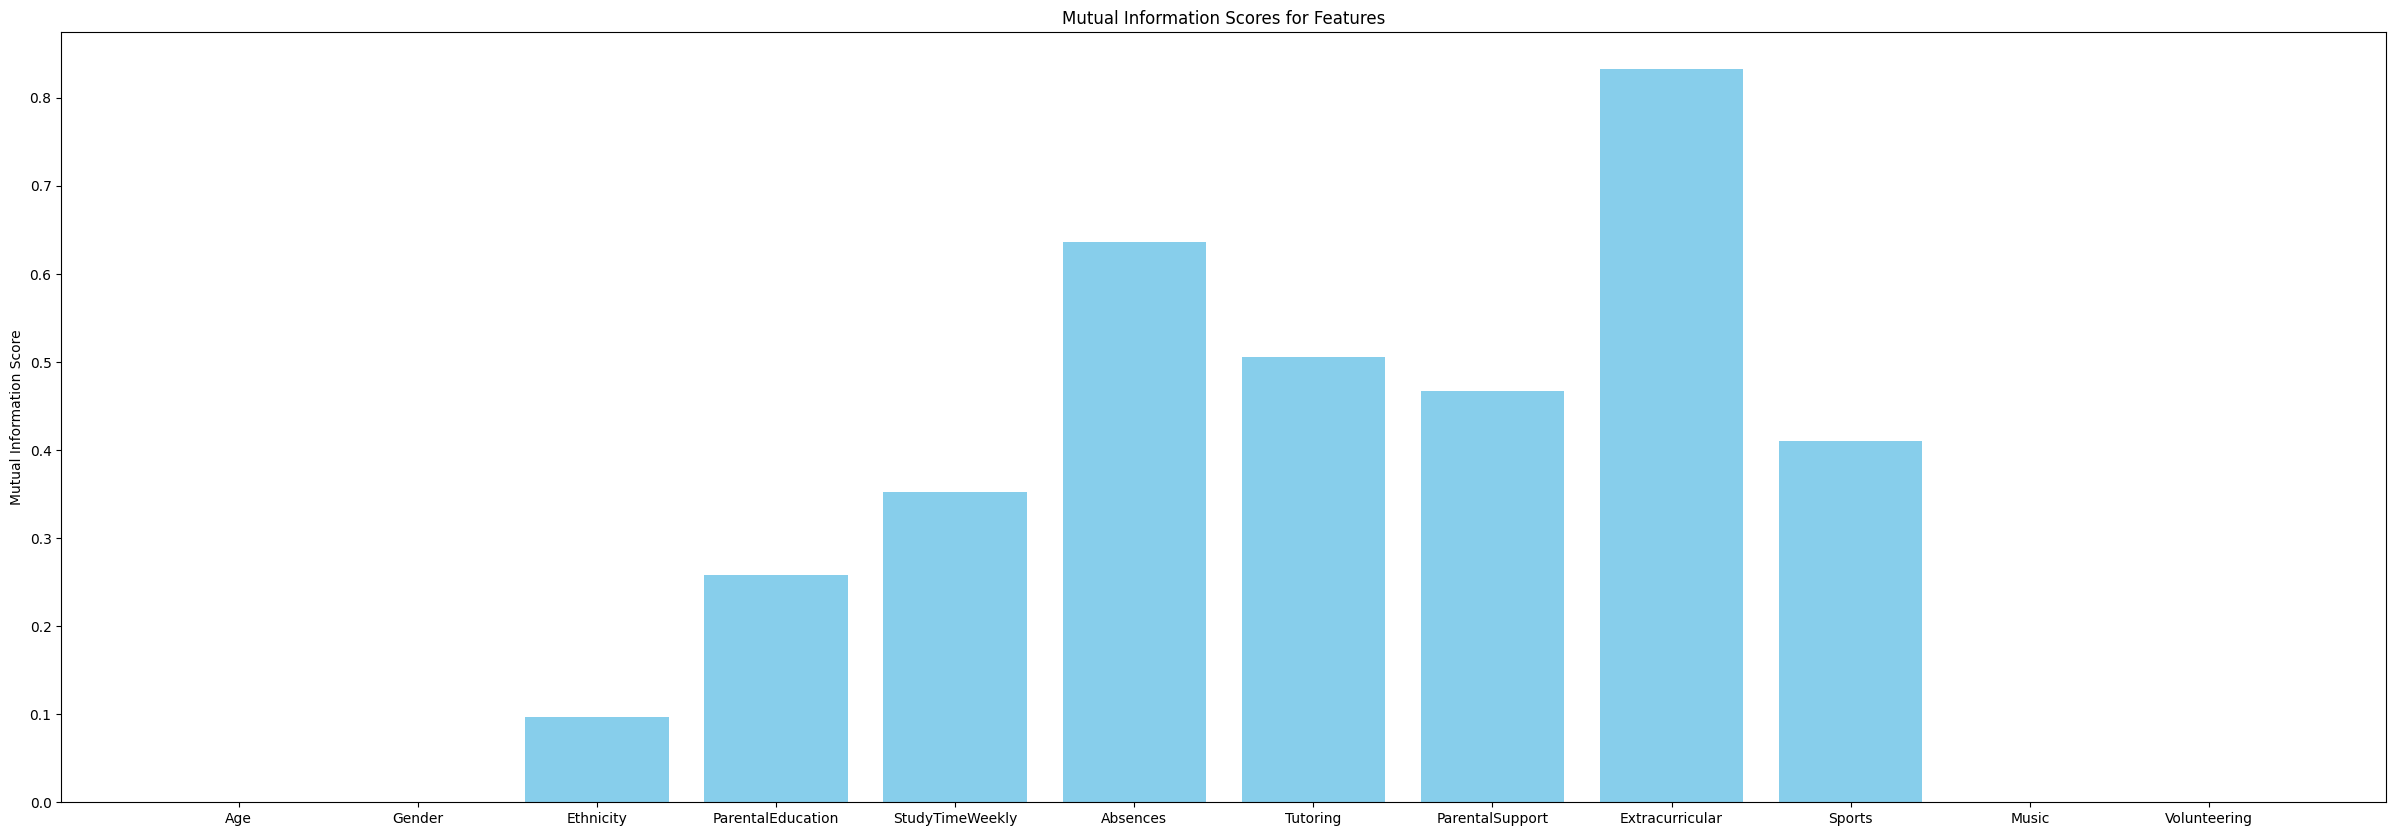

In [988]:
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.feature_selection import SelectKBest, mutual_info_classif

# --- 1. Encode categorical input features ---
cat_cols = X.select_dtypes(include=["object", "category"]).columns
encoder = OrdinalEncoder()
X_encoded = X.copy()
X_encoded[cat_cols] = encoder.fit_transform(X[cat_cols])

# --- 2. Encode GPA ONLY for MI step ---
le = LabelEncoder()
Y_encoded = le.fit_transform(df["GPA"])

# --- 3. Select best 8 features using Mutual Information (STABLE) ---
mi_selector = SelectKBest(
    score_func=lambda X, y: mutual_info_classif(X, y, random_state=42),
    k=8
)
mi_selector.fit(X_encoded, Y_encoded)

# MI scores
mi_scores = mi_selector.scores_

for col, score in zip(X.columns, mi_scores):
    print(f"{col}: {score}")

# Selected features
selected_features = X.columns[mi_selector.get_support()]
print("Selected features:", selected_features.tolist())

# Plot MI scores
plt.figure(figsize=(30, 10))
plt.bar(X.columns, mi_scores, color='skyblue')
# plt.xlabel('Features')
plt.ylabel('Mutual Information Score')
plt.title('Mutual Information Scores for Features')
plt.show()

X = X_encoded[selected_features]


In [989]:
# PCA for dimentionality reduction
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

df_pca = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
df_pca['Target'] = Y
df_pca


,PC1,PC2,Target
0,-0.574588,-1.258249,2.929196
1,-0.549473,-1.219918,3.042915
2,0.955444,-0.257278,0.112602
3,-0.597712,-1.351070,2.054218
4,-0.607541,-1.393389,1.288061
...,...,...,...
2387,-0.554315,-1.258703,1.191929
2388,-1.163619,-0.485863,1.810038
2389,-0.619149,-1.406408,2.539113
2390,-0.413992,0.040610,1.395631


## Regression

In [ ]:
# X = df.drop(columns=['GPA'])
# Y = df['GPA']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)
model.score(X_test, y_test)


# Predict

model.predict()

array([1.28533899, 3.01775476, 1.97769703, 3.68943358, 0.29505869,
       2.90495061, 1.66198211, 1.90725235, 2.07600693, 1.09591945,
       2.31550366, 0.85152509, 3.10015948, 2.72690467, 2.80902391,
       0.53587579, 1.12382378, 1.54923277, 1.82118514, 2.48818931,
       2.21228895, 1.65972273, 1.68211758, 3.26250968, 1.65596605,
       0.52732767, 1.66398116, 2.48425573, 2.2221564 , 1.84343156,
       1.88409784, 0.79930504, 3.05373243, 3.35755798, 1.63152203,
       1.84213219, 3.0576273 , 2.99477373, 3.13322222, 0.97724882,
       2.45981798, 3.39961551, 1.08238699, 2.22665363, 1.13219631,
       2.51968249, 2.91656503, 1.12057687, 2.8010301 , 1.49811683,
       3.01903986, 3.02004214, 1.61021644, 1.02232142, 1.92502277,
       3.37919111, 2.57211048, 3.48661207, 1.0625314 , 1.82721997,
       1.75449398, 1.68591924, 2.50970295, 1.67180737, 0.87810462,
       2.44683243, 3.3242102 , 2.61480723, 0.96752459, 3.65677667,
       3.22282123, 1.1449482 , 2.69358585, 2.66925113, 0.82819

## Export Model 

In [991]:
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType
import joblib
import json


#Save selected feature names 
selected_features_list = list(selected_features)
with open("selected_features.json", "w") as f:
    json.dump(selected_features_list, f)

# Export model to ONNX
n_features = X_train.shape[1]

onnx_model = convert_sklearn(
    model,
    initial_types=[("input", FloatTensorType([None, n_features]))]
)

with open("student_model.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())
